In [29]:
import json
import pandas as pd
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
with open('/content/drive/MyDrive/skin_treatment.json') as file:
    data = json.load(file)

In [32]:
print(data)

{'intents': [{'tag': 'greeting', 'input': ['Hi', 'Hello', 'Hey', 'Good morning', 'Good evening', 'Hi there', 'Hello there', 'Greetings', "What's up?", "How's it going?", 'How are you?'], 'responses': ['Hello! How can I assist you with your skincare today?', 'Hi there! How can I help with your skincare routine?', 'Hey! What skincare help do you need today?', 'Good to see you! What skincare questions do you have?', 'Hello! How can I make your skincare routine better today?']}, {'tag': 'common_skin_issues', 'input': ['What are common skin issues?', 'What are the most common skin problems?', 'What issues do people usually have with their skin?', 'What skin concerns should I be aware of?', 'What are common problems with skin care?'], 'responses': ['Some common skin issues include acne, dry skin, oily skin, hyperpigmentation, and signs of aging like wrinkles and fine lines.', "Skin problems can range from acne and dryness to oily skin, enlarged pores, and redness. It's important to understan

In [33]:
# Prepare the inputs and tags
tags = []
inputs = []
responses = {}
for intent in data['intents']:
    responses[intent['tag']] = intent['responses']
    for lines in intent['input']:
        inputs.append(lines)
        tags.append(intent['tag'])

In [34]:
df = pd.DataFrame({"inputs": inputs, "tags": tags})

In [35]:
df

,inputs,tags
0,Hi,greeting
1,Hello,greeting
2,Hey,greeting
3,Good morning,greeting
4,Good evening,greeting
...,...,...
164,See you,goodbye
165,Bye,goodbye
166,Take care,goodbye
167,Talk to you later,goodbye


preprocessing

In [36]:
#removing punctuations
import string
df['inputs'] = df['inputs'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
df['inputs'] = df['inputs'].apply(lambda wrd: ''.join(wrd))
df

,inputs,tags
0,hi,greeting
1,hello,greeting
2,hey,greeting
3,good morning,greeting
4,good evening,greeting
...,...,...
164,see you,goodbye
165,bye,goodbye
166,take care,goodbye
167,talk to you later,goodbye


In [37]:
# Tokenization
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df['inputs'])
train = tokenizer.texts_to_sequences(df['inputs'])

# Apply padding
x_train = pad_sequences(train)

# Encode the output
le = LabelEncoder()
y_train = le.fit_transform(df['tags'])

input_shape = x_train.shape[1]
print(input_shape)

# Define vocabulary
vocabulary = len(tokenizer.word_index)
print("Number of unique words: ", vocabulary)
output_length = le.classes_.shape[0]
print("Output length: ", output_length)

13
Number of unique words:  174
Output length:  22


In [38]:
i = Input(shape=(input_shape,))
x = Embedding(input_dim=vocabulary + 1, output_dim=128)(i)
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dense(output_length, activation='softmax')(x)

model = Model(inputs=i, outputs=x)

In [39]:
# Model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 13, 128)             │          22,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 22)                  │           1,430 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,398 (302.34 KB)

 Trainable params: 77,398 (302.34 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [43]:
#training the model
train = model.fit(x_train,y_train,epochs=100)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0020     
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0019 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0024 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0019 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0024 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0015 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0018 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0022 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0019 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 -

Text(0.5, 0, 'epoch')

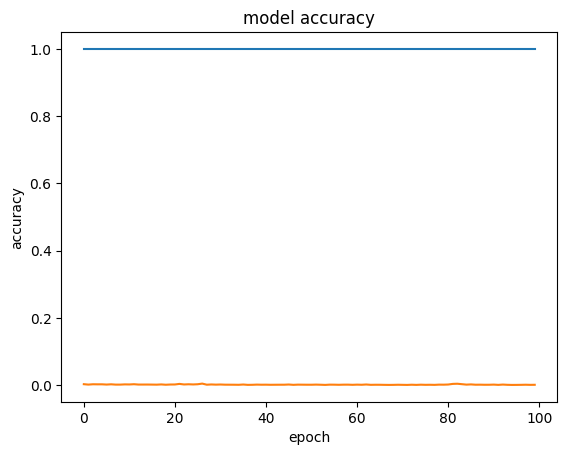

In [44]:
#plot accuracy
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'], label='training set loss')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [45]:
while True:
    texts_p = []
    prediction_input = input('You : ')

    # Removing punctuation and converting to lowercase
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = ''.join(prediction_input)
    texts_p.append(prediction_input)

    # Tokenizing and padding
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)

    # Getting output from model
    output = model.predict(prediction_input)
    output = output.argmax()

    # Finding the right tag and predictingh the response
    response_tag = le.inverse_transform([output])[0]
    print("beauskin: ", random.choice(responses[response_tag]))

    # Check for "goodbye" tag to end the conversation
    if response_tag == "goodbye":
        break

You : hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
beauskin:  Hi there! How can I help with your skincare routine?
You : how to determine my skin type?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
beauskin:  A simple test: after cleansing, if your skin is oily in the T-zone but normal or dry elsewhere, you have combination skin. Use a blotting sheet to check for oiliness. For an easier way, try using the face scan analysis feature in our Beauskin app. It can detect your skin type and provide insights about acne concerns.
You : i have dry skin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
beauskin:  To care for dry skin, focus on maintaining hydration and protecting your skin barrier. Use a gentle cleanser that won’t strip your skin of natural oils, and apply moisturizer immediately after washing to lock in moisture. Avoid using very hot water during showers or face washing, as it can worsen dryness. If you’re unsure about the best routine for your skin, consider consulting a skincare professional for pe

In [ ]:
print(tf.__version__)

2.17.1


In [46]:
model.save('/content/drive/MyDrive/model fix/chatbot_model.h5')

In [47]:
# Save tokenizer to JSON file
tokenizer_json = tokenizer.to_json()
with open('/content/drive/MyDrive/model fix/tokenizer.json', 'w') as json_file:
    json.dump(tokenizer_json, json_file)

print("Tokenizer saved successfully as 'tokenizer.json'")


Tokenizer saved successfully as 'tokenizer.json'
